Figures for paper

In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import matplotlib.ticker as ticker

# Fix Denisty Stream Function Y-axis

- Heatmap of density streamfunction anomaly
- Contours of period 1
- Y-axis scaled to volume per layer


    1. **Calculate volume per layer**:

       $
       V_i = dz_i \times UAREA
       $

    where $i$ denotes the layer index.

    2. **Aggregate densities along z**:

       - Convert the 2D density array into a 1D array by averaging along the z-axis.


    3. **Classify volumes by density**:
       - Define density classes (bins), e.g., $ \rho_1, \rho_2, \ldots, \rho_n $.
       - For each layer $ i $, find the density class $ \rho_k $ where $ \bar{\rho_i} $ belongs.
       - Sum the volumes of layers for each density class:

       $
       V_{\rho_k} = \sum_{i \in \text{class} \, k} V_i
       $



In [6]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0).squeeze()

replacement_value = 0
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
anom_smoc_ds = xr.open_dataset(smoc_file)

In [13]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
sigma_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc')

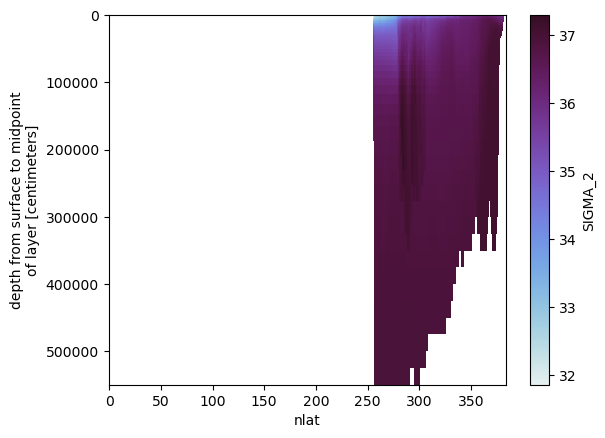

In [29]:
sigma_ds.SIGMA_2.mean(dim=['nlon', 'time']).plot(x='nlat', y='z_t', yincrease=False, cmap=cmo.dense)


In [35]:
nan_mask = sigma_ds.SIGMA_2.isel(time=0).notnull()

In [38]:
vol = (ds.TAREA * ds.dz).where(mask)

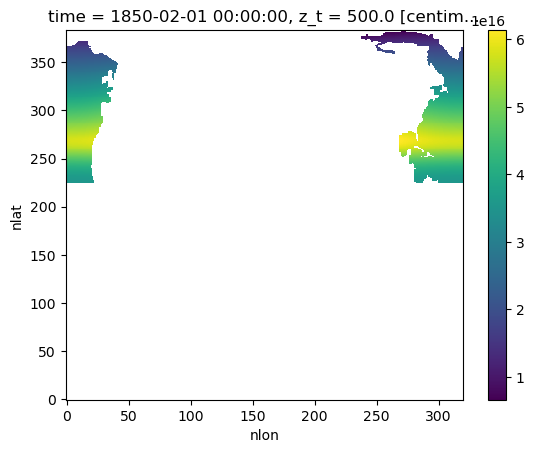

In [39]:
vol.isel(z_t=0).plot()

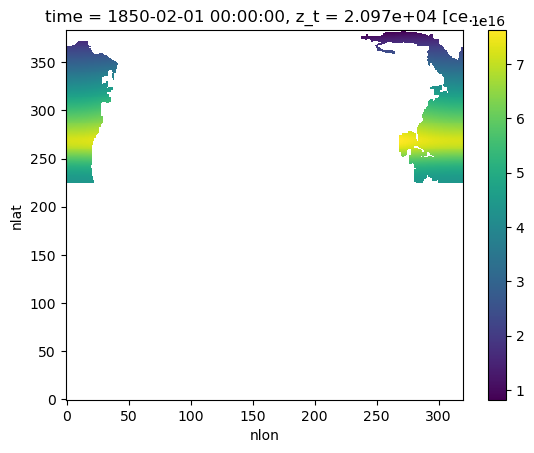

In [40]:
vol.isel(z_t=20).plot()

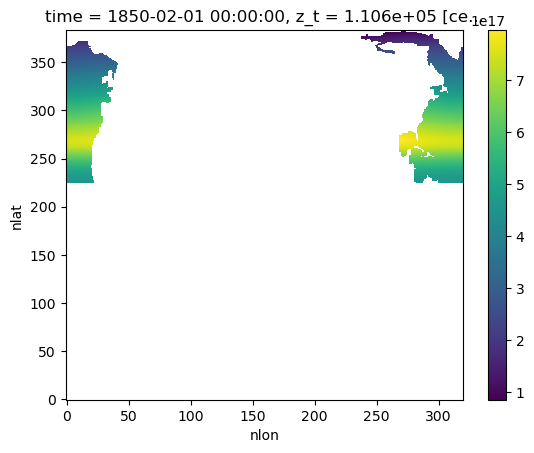

In [41]:
vol.isel(z_t=40).plot()

In [43]:
ds = ds_ps#.where(nan_mask)
vol_lat = (ds.TAREA * ds.dz).where(nan_mask).mean(dim=['nlon'])

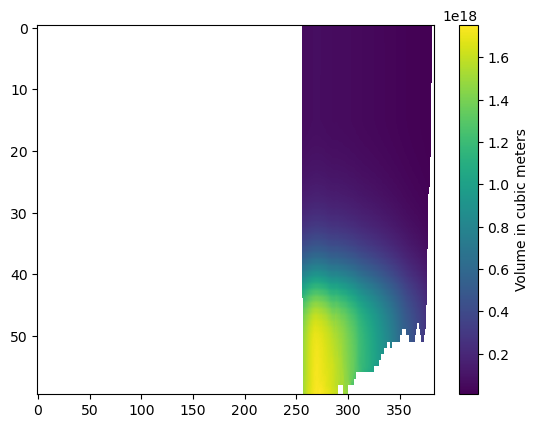

In [47]:
fig, ax = plt.subplots()
c = ax.imshow(vol_lat.T, origin='upper', cmap='viridis', aspect='auto')  # 'viridis' is one color map option, choose based on preference

# Add a colorbar
cbar = plt.colorbar(c, ax=ax)
cbar.set_label('Volume in cubic meters')

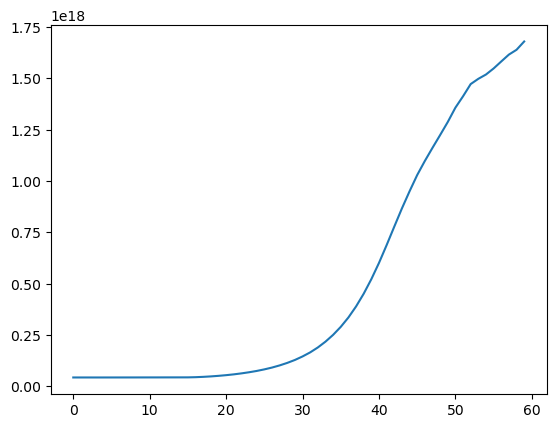

In [49]:
vol_av = (ds.TAREA * ds.dz).where(nan_mask).mean(dim=['nlon', 'nlat'])
plt.plot(vol_av)

In [7]:
z_lat_sigma = sigma_ds.mean(dim=['nlon', 'time'])

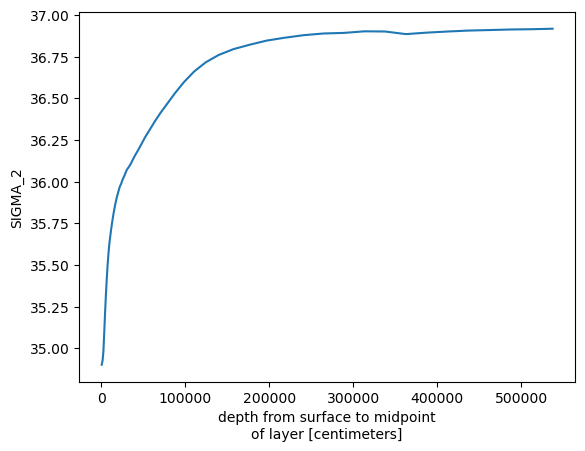

In [24]:
z_lat_sigma.SIGMA_2.mean('nlat').plot()

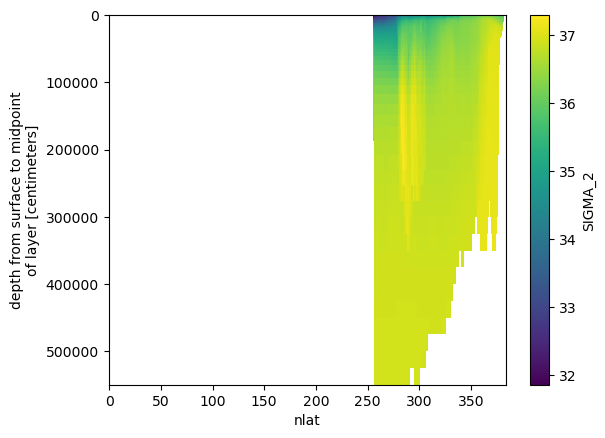

In [22]:
z_lat_sigma.SIGMA_2.plot(yincrease=False)

In [ ]:
# I want a graph that shows how much volume is there per depth level

In [ ]:
### scale y-axis ###

ds_sig = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc')

grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask3d = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
mask3d = mask3d.sum('region')

ds_sig = ds_sig.roll(nlon=+100).where(mask3d)
ds_sig = ds_sig.roll(nlon=-100)

In [ ]:
ds_vol = xr.open_dataset(temp_file).isel(time=0)
ds_vol = ds_vol.roll(nlon=+100).where(mask3d)
ds_vol = ds_vol.roll(nlon=-100)

In [9]:
# compute volume per layer 
volume_per_layer = (ds_vol['dz'] * ds_vol['UAREA']).mean(dim=('nlat', 'nlon')).values

# average density per grid volume
density_per_layer = ds_sig.SIGMA_2.mean(dim=('time', 'nlat', 'nlon')).values

density_classes = np.array([32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 
                            35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.3, 36.4, 
                            36.46, 36.54, 36.6, 36.65, 36.69, 36.73, 36.75, 36.78, 36.82, 36.84, 36.86, 
                            36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37.,])

# Classify average densities into density classes
density_class_indices = np.digitize(density_per_layer, bins=density_classes)

# Sum the volumes for each density class
volume_per_density_bin = np.zeros(len(density_classes) - 1)
for i in range(len(density_classes) - 1):
    volume_per_density_bin[i] = np.sum(volume_per_layer[i:i+2])
    

# Scale the y-axis (density) using the volume per density bin
# Compute the midpoints of density classes for plotting
density_midpoints = (density_classes[:-1] + density_classes[1:]) / 2

# Convert density values to indices of the volume per density bin
density_indices = np.digitize(density_midpoints, bins=density_classes) - 1

# Scale the y-axis (density) using the volume per density bin
# Compute the midpoints of density classes for plotting
density_midpoints = (density_classes[:-1] + density_classes[1:]) / 2

# Convert density values to indices of the volume per density bin
density_indices = np.digitize(density_midpoints, bins=density_classes) - 1

In [16]:
y_axis = np.arange(density_classes.shape[0])

TypeError: Dimensions of C (117, 115) should be one smaller than X(115) and Y(45) while using shading='flat' see help(pcolormesh)

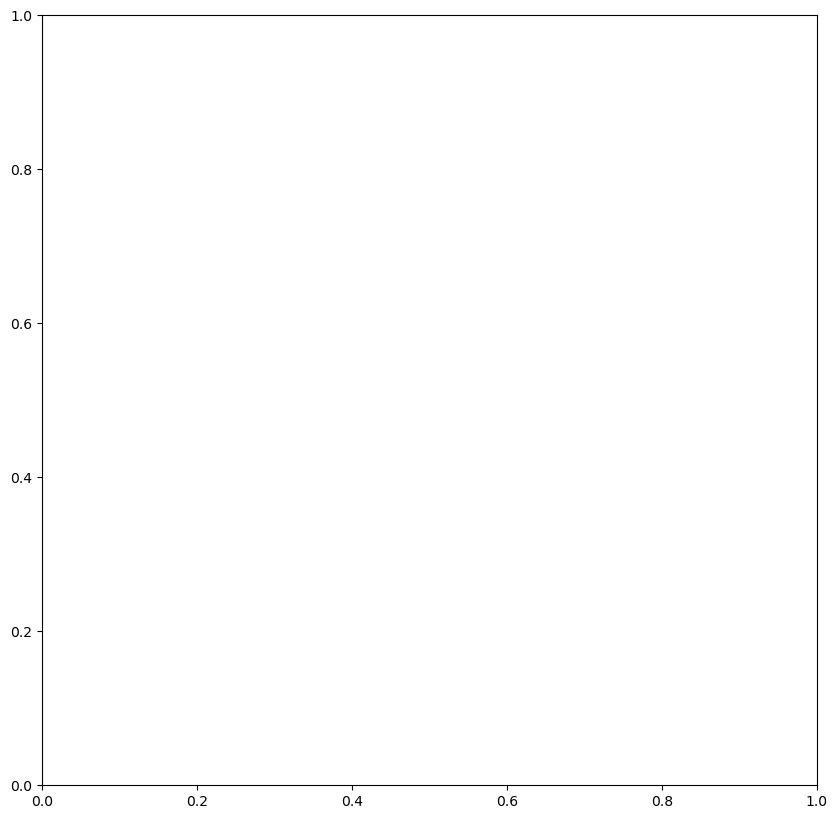

In [17]:

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), y_axis, anom_smoc_ds.densMOC,
                   cmap=cmo.balance)

plt.show()

IndexError: tuple index out of range

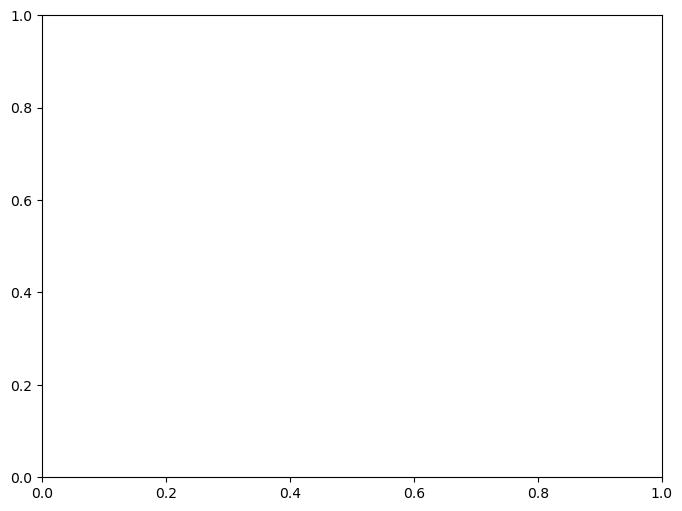

In [11]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(ds_ps.TLAT.isel(nlat=slice(250, 365)), len(density_classes), anom_smoc_ds.densMOC, cmap='viridis')
plt.colorbar(label='Data')
plt.ylabel('Density')
#plt.yticks(density_midpoints, [f"{density_classes[i]}-{density_classes[i+1]}" for i in range(len(density_classes) - 1)])
plt.xlabel('Latitude')
plt.title('2D Data Array with Scaled Y-Axis')
plt.grid(False)
plt.show()

In [15]:
vmin = -12.5
vmax = -vmin

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

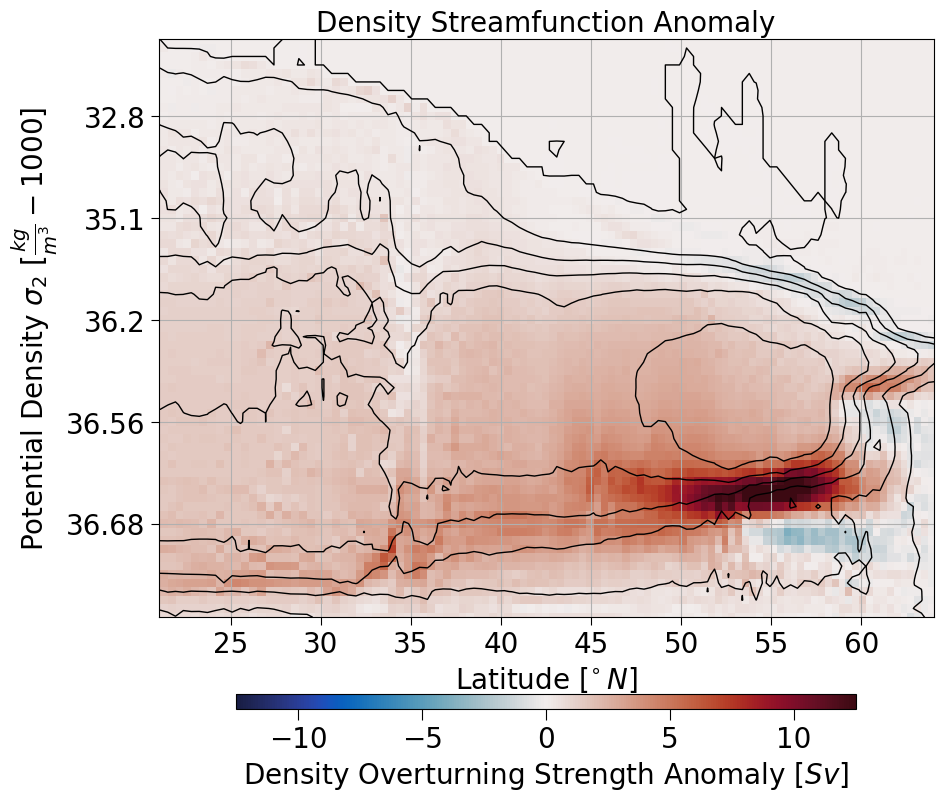

In [16]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, anom_smoc_ds.densMOC,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

plt.show()

#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Figure_2.png', bbox_inches='tight', dpi=300)

In [ ]:
import numpy as np
import xarray as xr

# Assuming 'ds' is your dataset and 'density_classes' is your 1D array for density class borders
# 'mean_density_per_layer' is the average density per layer (computed previously)
# 'mean_volume_per_layer' is the volume per layer (computed previously)

# Example density classes (borders)
density_classes = np.array([20, 22, 24, 26, 28, 30])

# Classify average densities into density classes
density_class_indices = np.digitize(mean_density_per_layer, bins=density_classes)

# Initialize an array to store the volume per density class
volume_per_density_class = np.zeros(len(density_classes) + 1)

# Sum the volumes for each density class
for i, class_index in enumerate(density_class_indices):
    volume_per_density_class[class_index] += mean_volume_per_layer[i]

# Output the volume per density class
for i in range(len(density_classes) + 1):
    if i == 0:
        print(f"Volume for density < {density_classes[0]}: {volume_per_density_class[i]}")
    elif i == len(density_classes):
        print(f"Volume for density >= {density_classes[-1]}: {volume_per_density_class[i]}")
    else:
        print(f"Volume for {density_classes[i-1]} <= density < {density_classes[i]}: {volume_per_density_class[i]}")